# Evaluation


In [1]:
import h5py
import numpy as np
import seaborn as sns
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import rcParams

from config import SpectrogramClassificationConfig, LatentSpectrogramConfig
from tqdne.metric import AmplitudeSpectralDensity, frechet_distance
from tqdne.dataset import Dataset
from tqdne.plot import BinPlot, MovingAverageEnvelopeGrid, AmplitudeSpectralDensityGrid

/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/seisbench/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Setup

In [4]:
train = h5py.File("workdir/evaluation/outputs-split_train-rank_0.h5", "r")
validation = h5py.File("workdir/evaluation/outputs-split_validation-rank_0.h5", "r")
test = h5py.File("workdir/evaluation/outputs-split_test-rank_0.h5", "r")

In [5]:
config = SpectrogramClassificationConfig("workdir")
mag_bins = config.mag_bins
dist_bins = config.dist_bins
evaluation_dir =  "workdir/evaluation/"

# Matplotlib settings
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = False
rcParams["font.size"] = 16

## Data distribution
Create the plot for the binning of the data and the heatmap for the number of samples in each bin.

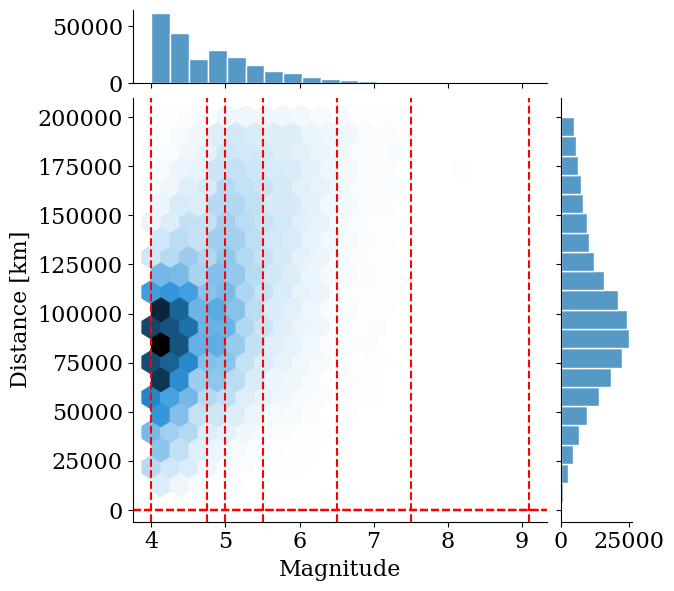

In [6]:
mag = np.concatenate([train.file["magnitude"][:], validation.file["magnitude"][:], test.file["magnitude"][:]])
dist = np.concatenate([train.file["hypocentral_distance"][:], validation.file["hypocentral_distance"][:], test.file["hypocentral_distance"][:]])
fig = sns.jointplot(
    x=mag,
    y=dist * 1000,
    kind="hex",
    marginal_ticks=True,
    joint_kws=dict(gridsize=20),
    marginal_kws=dict(bins=20, edgecolor="white"),
)
# plot.figure.set_size_inches([fig_width, fig_width])
plt.xlabel("Magnitude")
plt.ylabel("Distance [km]")

# draw bins
for x in mag_bins:
    plt.axvline(x, color="red", linestyle="--")
for y in dist_bins:
    plt.axhline(y, color="red", linestyle="--")

fig.savefig("workdir/figures/binning.pdf")

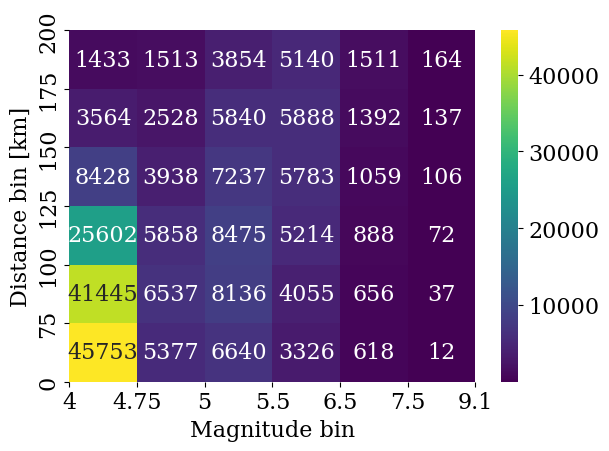

In [7]:
size_metric = lambda x, *args, **kwargs: len(x)
fig = BinPlot(metric=size_metric, mag_bins=mag_bins, dist_bins=dist_bins, fmt="d")(
    pred=mag, target=mag, mag=mag, dist=dist
)
fig.savefig("workdir/figures/class_distribution.pdf")

## Embedding Frechet Distance (FID)

In [28]:
print(
    f"Train vs Generated (Test): {round(frechet_distance(np.concatenate([train['target_classifier_embedding'][:], validation['target_classifier_embedding'][:]]), test['predicted_classifier_embedding'][:],  isotropic=True), 2 )}"
)
print(
    f"Train vs Test: {            round(frechet_distance(np.concatenate([train['target_classifier_embedding'][:], validation['target_classifier_embedding'][:]]), test['target_classifier_embedding'][:], isotropic=True), 2)}"
)

Train vs Generated (Test): 0.25999999046325684
Train vs Test: 0.10999999940395355


In [9]:
def frechet_distance(x: np.ndarray, y: np.ndarray, isotropic=False, eps=1e-6):
    """Compute the Frechet Distance between two sets of samples."""

    mu_x = np.nanmean(x, axis=0)
    mu_y = np.nanmean(y, axis=0)    

    if isotropic:
        std_x = np.nanstd(x, axis=0)
        std_y = np.nanstd(y, axis=0)
        return np.sum((mu_x - mu_y) ** 2) + np.sum((std_x - std_y) ** 2)

    cov_x = np.cov(x, rowvar=False)
    cov_y = np.cov(y, rowvar=False)

    # # Product might be almost singular
    covmean, _ = linalg.sqrtm(cov_x @ cov_y, disp=False)
    if not np.isfinite(covmean).all():
        print(
            f"fid calculation produces singular product; adding {eps} to diagonal of cov estimates"
        )
        offset = np.eye(cov_x.shape[0]) * eps
        covmean = linalg.sqrtm((cov_x + offset) @ (cov_y + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError(f"Imaginary component {np.max(np.abs(covmean.imag))}")
        covmean = covmean.real

    return np.sum((mu_x - mu_y) ** 2) + np.trace(cov_x) + np.trace(cov_y) - 2 * np.trace(covmean)

In [10]:
class BinningPlot:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metric = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def plot(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])                               
                if len(pred[mask]) and len(target[mask]):
                    try:
                        results[i].append(self.metric(pred[mask], target[mask]))
                    except ValueError as e:                        
                        results[i].append(np.nan)
                else:
                    results[i].append(0)

        # Plotting the heatmap using seaborn
        plot = sns.heatmap(np.array(results), annot=True, fmt=self.fmt, cmap="viridis")
        plot.set_xticks(np.arange(len(self.mag_bins)))
        plot.set_xticklabels(self.mag_bins)
        plot.set_yticks(np.arange(len(self.dist_bins)))
        plot.set_yticklabels(self.dist_bins)
        plot.invert_yaxis()
        plot.set_xlabel("Magnitude bin")
        plot.set_ylabel("Distance bin [km]")
        fig = plot.get_figure()
        fig.tight_layout()
        return fig

In [12]:
class BinningPlotMatrix:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metric = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def __call__(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])                               
                if len(pred[mask]) and len(target[mask]):
                    try:
                        results[i].append(self.metric(pred[mask], target[mask]))
                    except ValueError as e:                        
                        results[i].append(np.nan)
                else:
                    results[i].append(0)        
        return results        

/tmp/ipykernel_134991/3583514326.py:16: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(cov_x @ cov_y, disp=False)


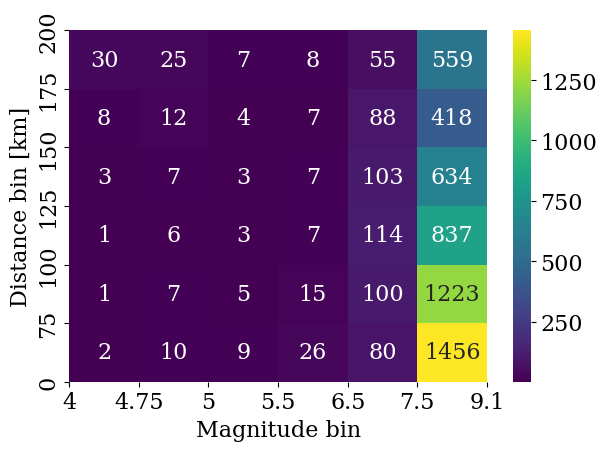

In [13]:
fid_metric = lambda x, y: frechet_distance(x, y, isotropic=False)
fig = BinningPlot(metric=fid_metric, mag_bins=mag_bins, dist_bins=dist_bins , fmt=".0f").plot(
    pred=np.concatenate([train["predicted_classifier_embedding"][:], validation["predicted_classifier_embedding"][:], test["predicted_classifier_embedding"][:]]),
    target=np.concatenate([train["target_classifier_embedding"][:], validation["target_classifier_embedding"][:], test["target_classifier_embedding"][:]]),
    mag=np.concatenate([train["magnitude"][:], validation["magnitude"][:], test["magnitude"][:]]),
    dist=np.concatenate([train["hypocentral_distance"][:], validation["hypocentral_distance"][:], test["hypocentral_distance"][:]]),
)
fig.savefig("workdir/figures/embedding_fd_heatmap.pdf")

/tmp/ipykernel_134991/3583514326.py:16: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(cov_x @ cov_y, disp=False)


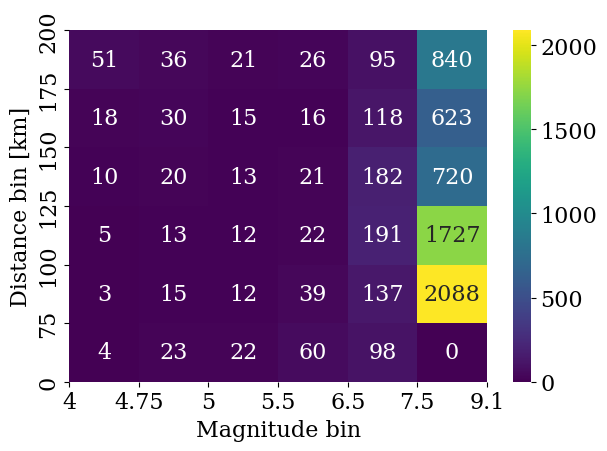

In [14]:
fid_metric = lambda x, y: frechet_distance(x, y, isotropic=False)
mat = BinningPlotMatrix(metric=fid_metric, mag_bins=mag_bins, dist_bins=dist_bins , fmt=".0f")(
    pred=test["predicted_classifier_embedding"][:],
    target=test["target_classifier_embedding"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig = BinningPlot(metric=fid_metric, mag_bins=mag_bins, dist_bins=dist_bins , fmt=".0f").plot(
    pred=test["predicted_classifier_embedding"][:],
    target=test["target_classifier_embedding"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)

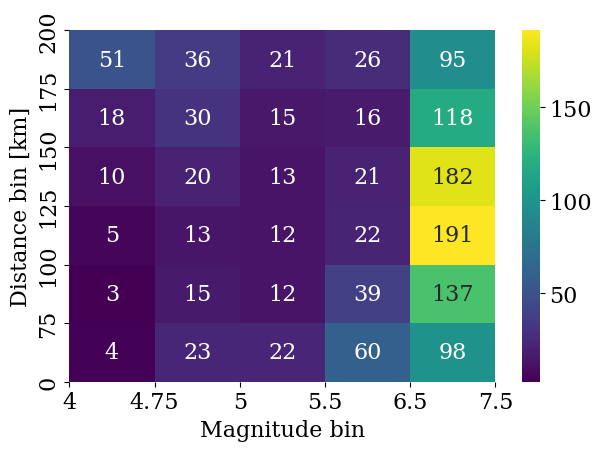

In [15]:
results = np.array(mat)[:,:-1]
plot = sns.heatmap(results, annot=True, fmt=".0f", cmap="viridis")
plot.set_xticks(np.arange(len(mag_bins[:-1])))
plot.set_xticklabels(mag_bins[:-1])
plot.set_yticks(np.arange(len(dist_bins)))
plot.set_yticklabels(dist_bins)
plot.invert_yaxis()
plot.set_xlabel("Magnitude bin")
plot.set_ylabel("Distance bin [km]")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig("workdir/figures/embedding_fd_heatmap-test.pdf")

## Classifier Accuracy

In [16]:
def get_label(mag, dist):
    return (np.digitize(dist, dist_bins) - 1) * (len(mag_bins) - 1) + np.digitize(mag, mag_bins) - 1


def accuracy(logits, labels):
    return (logits.argmax(axis=-1) == labels).mean() * 100

In [17]:
np.unique(get_label(train['magnitude'][:], train['hypocentral_distance'][:]), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 array([38946,  4601,  5593,  2826,   510,    11, 35225,  5553,  6877,
         3440,   549,    31, 21797,  4950,  7195,  4467,   766,    60,
         7181,  3329,  6159,  4922,   914,    84,  3022,  2169,  4969,
         5014,  1168,   112,  1221,  1288,  3248,  4350,  1294,   142]))

In [18]:
len(train['magnitude'][:])

193983

In [19]:
np.unique(get_label(train['magnitude'][:], train['hypocentral_distance'][:]), return_counts=True)[1][0]/len(train['magnitude'][:])

np.float64(0.2007701705819582)

In [20]:
print(
    f"Generated Test: {round(accuracy(test['predicted_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:] )), 2)} %"
)
print(
    f"Test: {round(accuracy(test['target_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:] )), 2)} %"
)

Generated Test: 67.74 %
Test: 69.31 %


In [21]:
class BinningPlotAcc:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metric = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def plot(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])                               
                if len(pred[mask]) and len(target[mask]):
                    try:
                        results[i].append(self.metric(pred[mask], target[mask]))
                    except ValueError as e:
                        print(e)                        
                        print("----")
                        print(pred[mask].shape)    
                        results[i].append(np.nan)
                else:
                    results[i].append(0)

        # Plotting the heatmap using seaborn
        plot = sns.heatmap(np.array(results), annot=True, fmt=self.fmt, cmap="plasma")
        plot.set_xticks(np.arange(len(self.mag_bins)))
        plot.set_xticklabels(self.mag_bins)
        plot.set_yticks(np.arange(len(self.dist_bins)))
        plot.set_yticklabels(self.dist_bins)
        plot.invert_yaxis()
        plot.set_xlabel("Magnitude bin")
        plot.set_ylabel("Distance bin [km]")
        fig = plot.get_figure()
        fig.tight_layout()
        return fig
    
class BinningPlotAccMatrix:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metric = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def __call__(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])                               
                if len(pred[mask]) and len(target[mask]):
                    try:
                        results[i].append(self.metric(pred[mask], target[mask]))
                    except ValueError as e:
                        print(e)                        
                        print("----")
                        print(pred[mask].shape)    
                        results[i].append(np.nan)
                else:
                    results[i].append(0)
        return results

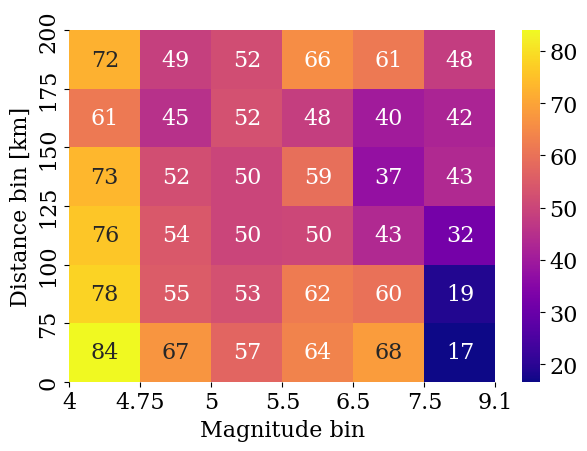

In [22]:
fig = BinningPlotAcc(metric=accuracy, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=np.concatenate([train['predicted_classifier_pred'][:], validation['predicted_classifier_pred'][:], test['predicted_classifier_pred'][:]]),
    target=get_label(
        np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]), np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]) 
    ),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]),
)
fig.savefig("workdir/figures/accuracy_heatmap.pdf")

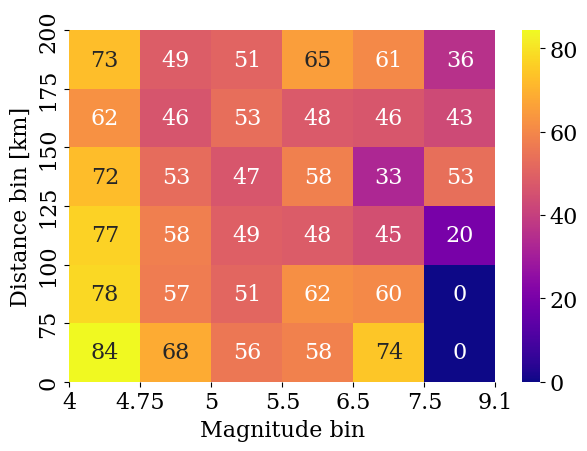

In [23]:

mat = BinningPlotAccMatrix(metric=accuracy, mag_bins=mag_bins, dist_bins=dist_bins , fmt=".0f")(
    pred=test['predicted_classifier_pred'][:],
    target=get_label(test['magnitude'][:], test['hypocentral_distance'][:]),
    mag=test['magnitude'][:],
    dist=test['hypocentral_distance'][:],
)
fig = BinningPlotAcc(metric=accuracy, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=test['predicted_classifier_pred'][:],
    target=get_label(test['magnitude'][:], test['hypocentral_distance'][:]),
    mag=test['magnitude'][:],
    dist=test['hypocentral_distance'][:],
)

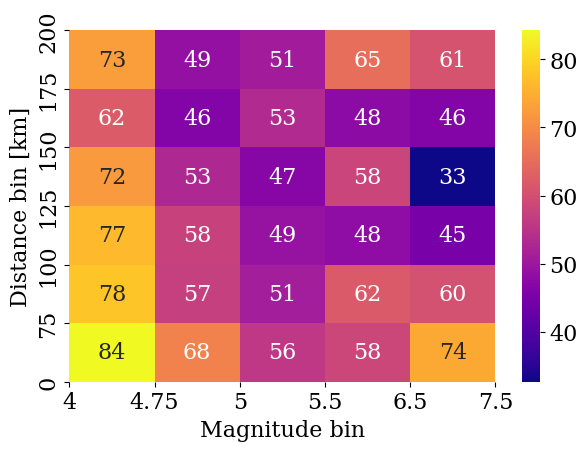

In [24]:
results = np.array(mat)[:, :-1]
plot = sns.heatmap(results, annot=True, fmt=".0f", cmap="plasma")
plot.set_xticks(np.arange(len(mag_bins[:-1])))
plot.set_xticklabels(mag_bins[:-1])
plot.set_yticks(np.arange(len(dist_bins)))
plot.set_yticklabels(dist_bins)
plot.invert_yaxis()
plot.set_xlabel("Magnitude bin")
plot.set_ylabel("Distance bin [km]")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig("workdir/figures/accuracy_heatmap-test.pdf")

## Amplitude Spectral Density

In [27]:
print(
    f"Channel 0: Train vs Generated: {round(AmplitudeSpectralDensity(100, 0)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['predicted_waveform'][:]), 2)}"
)

print(
    f"Channel 0: Train vs Test: {round(AmplitudeSpectralDensity(100, 0)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['target_waveform'][:]), 2)}"
)


print(
    f"Channel 1: Train vs Generated: {round(AmplitudeSpectralDensity(100, 1)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['predicted_waveform'][:]), 2)}"
)

print(
    f"Channel 1: Train vs Test: {round(AmplitudeSpectralDensity(100, 1)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['target_waveform'][:]), 2)}"
)


print(
    f"Channel 2: Train vs Generated: {round(AmplitudeSpectralDensity(100, 2)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['predicted_waveform'][:]), 2)}"
)

print(
    f"Channel 2: Train vs Test: {round(AmplitudeSpectralDensity(100, 2)(np.concatenate([train['target_waveform'][:], validation['target_waveform'][:]]), test['target_waveform'][:]), 2)}"
)


Channel 0: Train vs Generated: 22.459999084472656
Channel 0: Train vs Test: 0.28999999165534973
Channel 1: Train vs Generated: 20.559999465942383
Channel 1: Train vs Test: 0.3799999952316284
Channel 2: Train vs Generated: 24.649999618530273
Channel 2: Train vs Test: 0.41999998688697815


In [24]:
class BinPlotMultiMetric:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metrics = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def plot(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])
                ret = np.array([metric(pred[mask], target[mask]) for metric in self.metrics])
                results[i].append(np.mean(ret))

        # Plotting the heatmap using seaborn
        plot = sns.heatmap(np.array(results), annot=True, fmt=self.fmt, cmap="viridis")
        plot.set_xticks(np.arange(len(self.mag_bins)))
        plot.set_xticklabels(self.mag_bins)
        plot.set_yticks(np.arange(len(self.dist_bins)))
        plot.set_yticklabels(self.dist_bins)
        plot.invert_yaxis()
        plot.set_xlabel("Magnitude bin")
        plot.set_ylabel("Distance bin [km]")
        fig = plot.get_figure()
        fig.tight_layout()
        return fig

class BinPlotMultiMetricMatrix:
    """Creates a bin plot for a given metric."""

    def __init__(self, metric, mag_bins, dist_bins, fmt=".2f"):
        super().__init__()
        self.metrics = metric
        self.mag_bins = mag_bins
        self.dist_bins = dist_bins
        self.fmt = fmt

    @property
    def name(self):
        return f"Bin {self.metric.name}"

    def __call__(self, pred, target, mag, dist):
        # compute metrics for each bin
        results = []
        for i in range(len(self.dist_bins) - 1):
            results.append([])
            for j in range(len(self.mag_bins) - 1):
                mask = (dist >= self.dist_bins[i]) & (dist < self.dist_bins[i + 1])
                mask &= (mag >= self.mag_bins[j]) & (mag < self.mag_bins[j + 1])
                ret = np.array([metric(pred[mask], target[mask]) for metric in self.metrics])
                results[i].append(np.mean(ret))
        return results

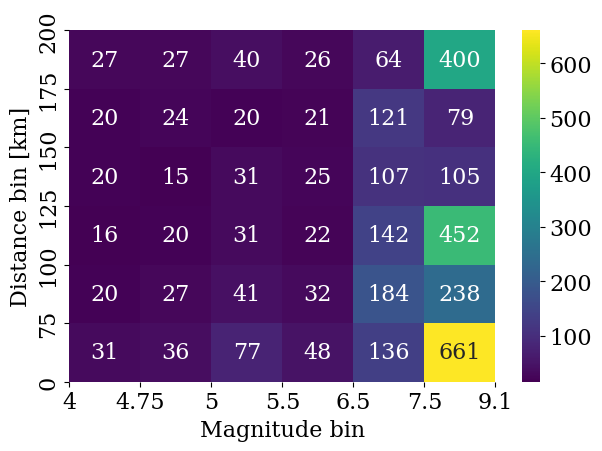

In [25]:
fig = BinPlotMultiMetric(metric=[AmplitudeSpectralDensity(100, 0, isotropic=True), AmplitudeSpectralDensity(100, 1, isotropic=True), AmplitudeSpectralDensity(100, 2, isotropic=True)], mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]),
)
fig.savefig("workdir/figures/asd_heatmap.pdf")

/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/src/tqdne/tqdne/metric.py:16: RuntimeWarning: Mean of empty slice.
  mu_x = x.mean(0)
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/src/tqdne/tqdne/metric.py:17: RuntimeWarning: Mean of empty slice.
  mu_y = y.mean(0)
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workd

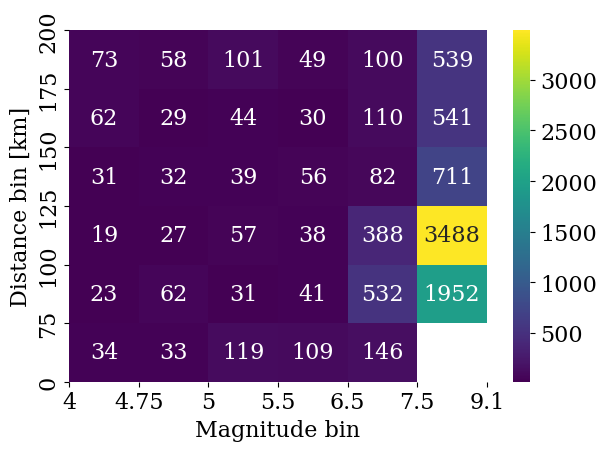

In [26]:
mat = BinPlotMultiMetricMatrix(metric=[AmplitudeSpectralDensity(100, 0, isotropic=True), AmplitudeSpectralDensity(100, 1, isotropic=True), AmplitudeSpectralDensity(100, 2, isotropic=True)], mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=test['predicted_waveform'][:],
    target= test['target_waveform'][:],
    mag= test['magnitude'][:],
    dist= test['hypocentral_distance'][:],
)
fig = BinPlotMultiMetric(metric=[AmplitudeSpectralDensity(100, 0, isotropic=True), AmplitudeSpectralDensity(100, 1, isotropic=True), AmplitudeSpectralDensity(100, 2, isotropic=True)], mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f").plot(
    pred=test['predicted_waveform'][:],
    target= test['target_waveform'][:],
    mag= test['magnitude'][:],
    dist= test['hypocentral_distance'][:],
)

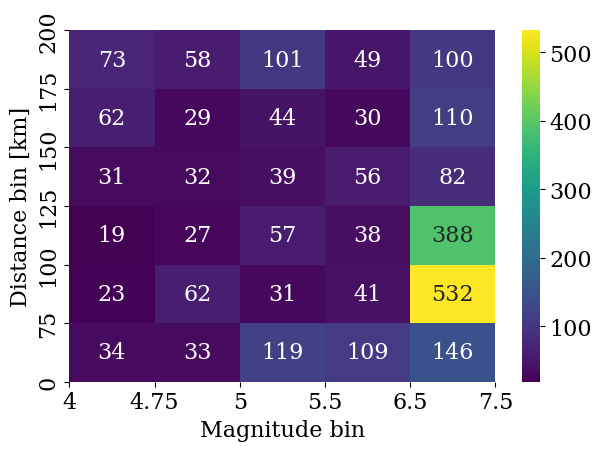

In [27]:
results = np.array(mat)[:, :-1]
plot = sns.heatmap(results, annot=True, fmt=".0f", cmap="viridis")
plot.set_xticks(np.arange(len(mag_bins[:-1])))
plot.set_xticklabels(mag_bins[:-1])
plot.set_yticks(np.arange(len(dist_bins)))
plot.set_yticklabels(dist_bins)
plot.invert_yaxis()
plot.set_xlabel("Magnitude bin")
plot.set_ylabel("Distance bin [km]")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig("workdir/figures/asd_heatmap-test.pdf")

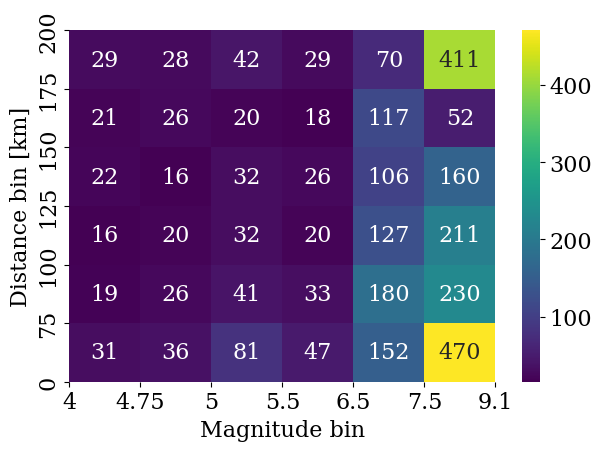

In [28]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 0, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]),
)
fig.savefig("workdir/figures/asd_heatmap_0.pdf")

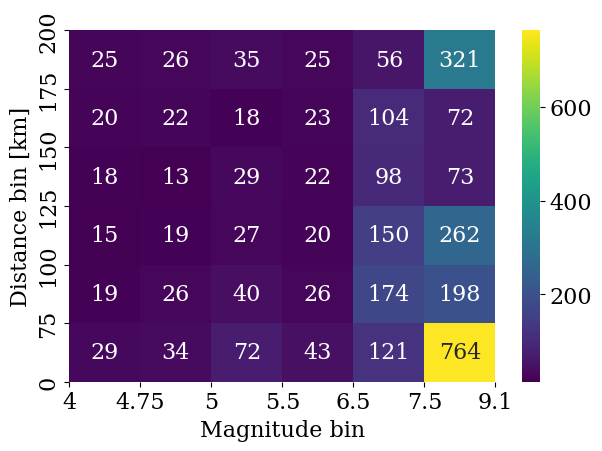

In [29]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 1, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]),
)
fig.savefig("workdir/figures/asd_heatmap_1.pdf")

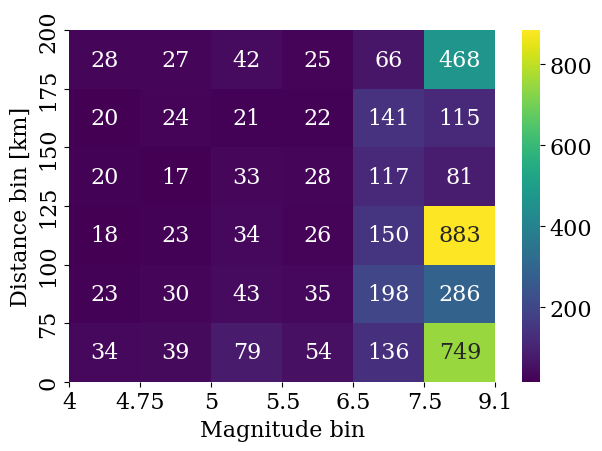

In [30]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 2, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=np.concatenate([train['predicted_waveform'][:], validation['predicted_waveform'][:], test['predicted_waveform'][:]]),
    target=np.concatenate([train['target_waveform'][:], validation['target_waveform'][:], test['target_waveform'][:]]),
    mag=np.concatenate([train['magnitude'][:], validation['magnitude'][:], test['magnitude'][:]]),
    dist=np.concatenate([train['hypocentral_distance'][:], validation['hypocentral_distance'][:], test['hypocentral_distance'][:]]),
)
fig.savefig("workdir/figures/asd_heatmap_2.pdf")

## Grid plot

In [31]:
distance_bins = config.dist_bins
magnitude_bins = config.mag_bins
channel = 2

/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/src/tqdne/tqdne/plot.py:239: RuntimeWarning: Mean of empty slice.
  mean = transformed.mean(axis=0)
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/_core/_methods.py:216: RuntimeWarning: invalid value encountered in

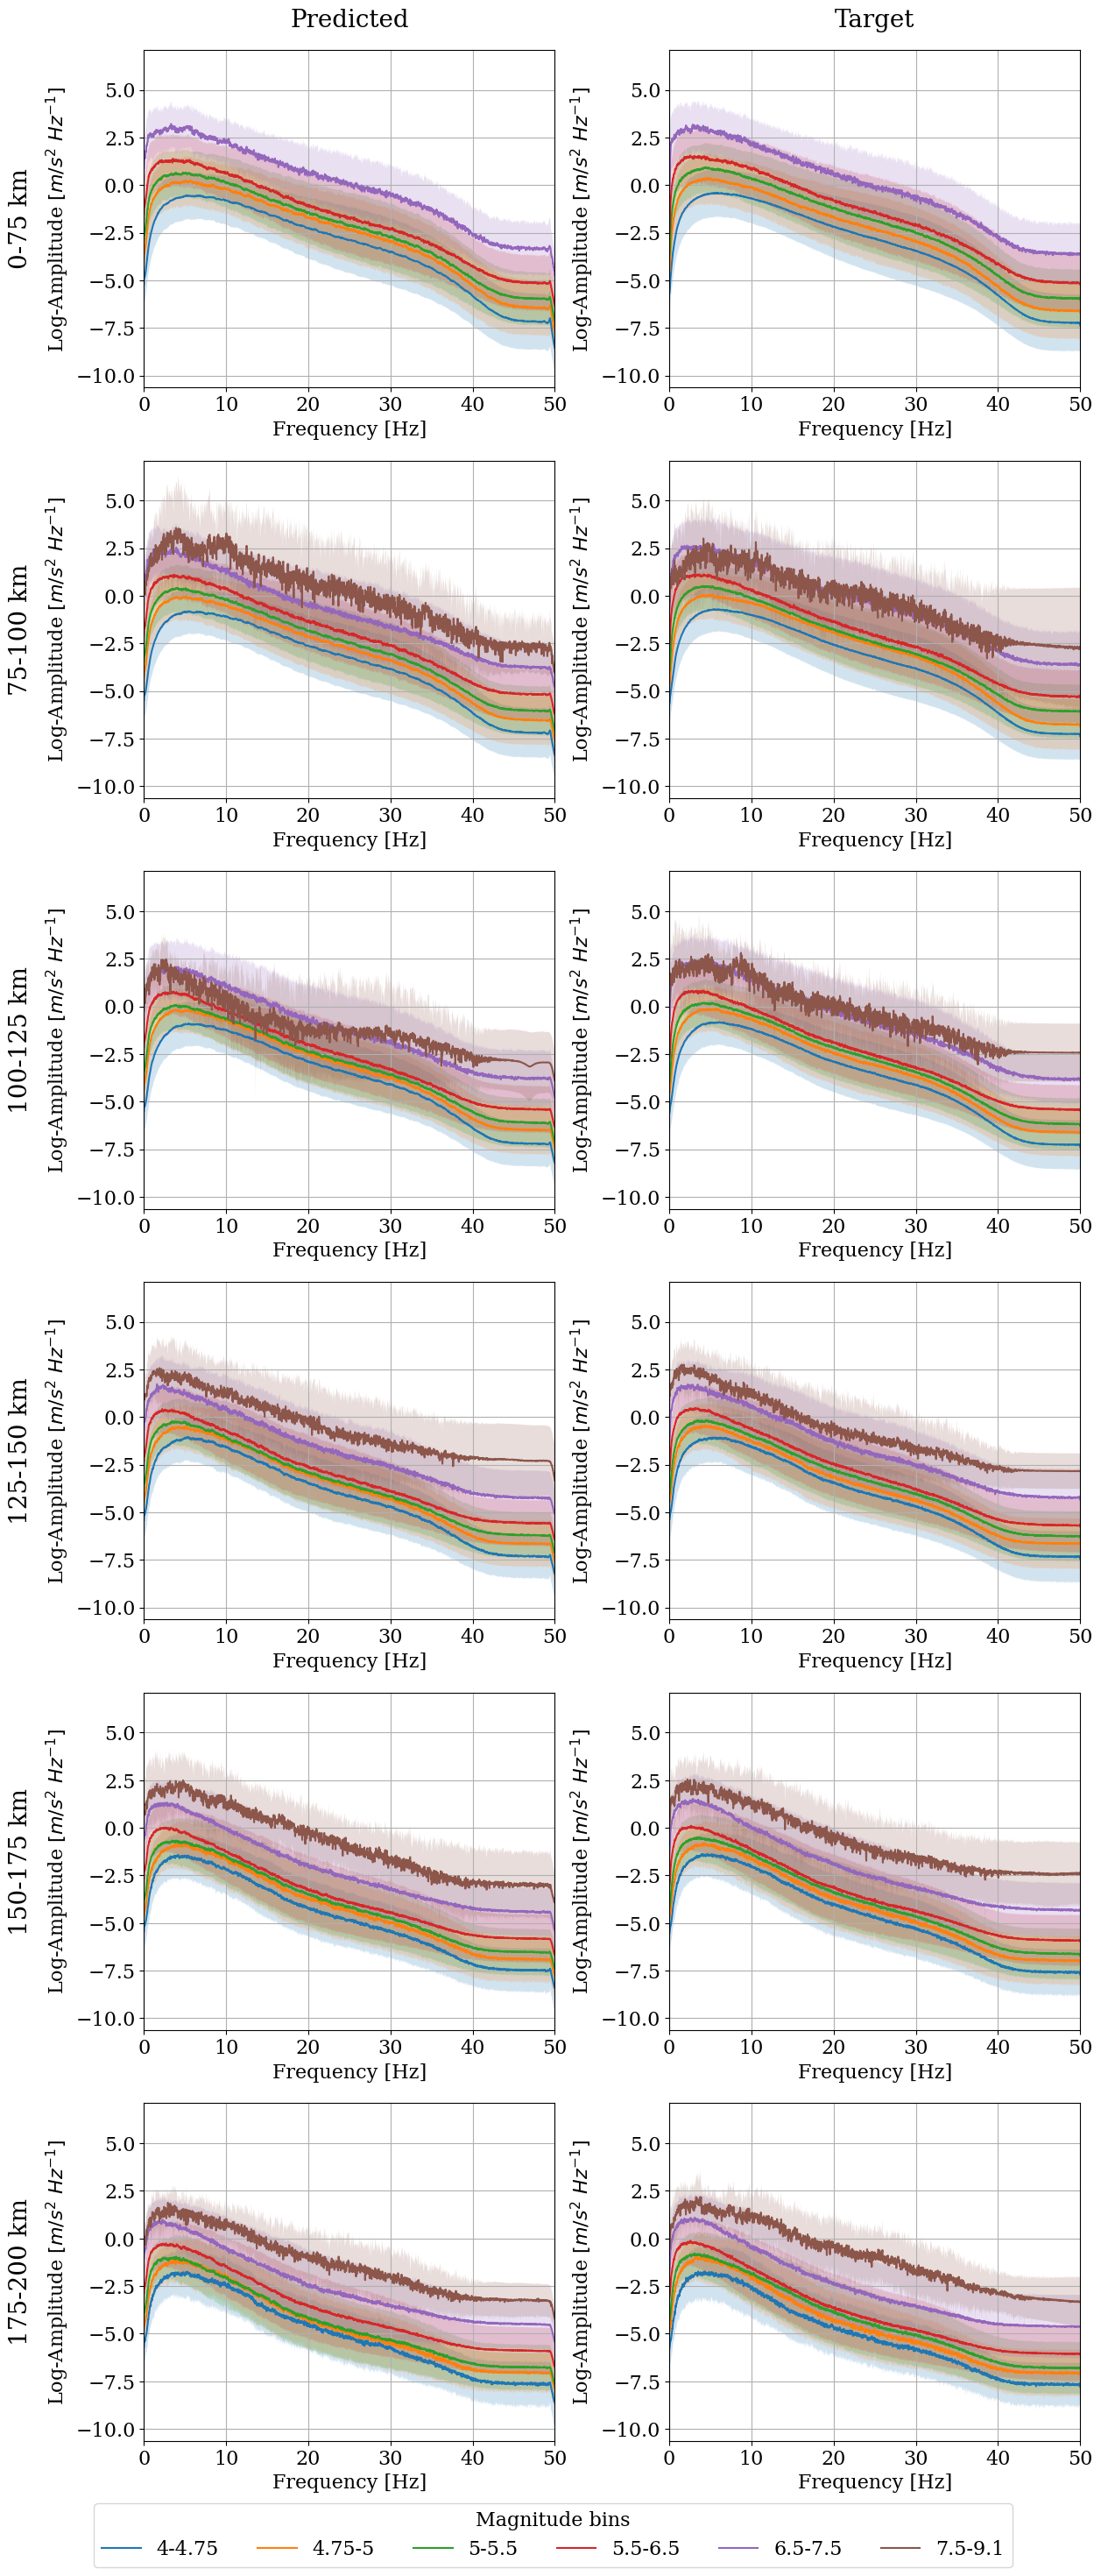

In [32]:
fig = AmplitudeSpectralDensityGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig(f"workdir/figures/asd_grid_{channel}.pdf", bbox_inches="tight")

### Single distance bin

In [33]:
distance_bins = [0, 200]
magnitude_bins = [4.5, 5.0, 5.5, 6.0, 7.0, 9.0]

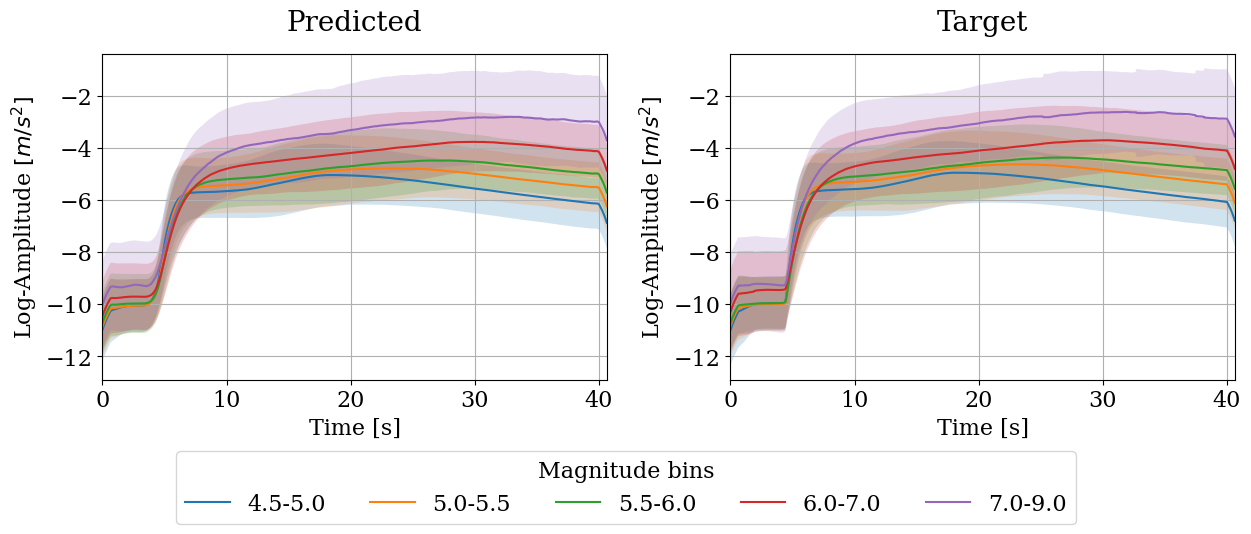

In [34]:
fig = MovingAverageEnvelopeGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig("workdir/figures/moving_average_envelope_small_grid.pdf", bbox_inches="tight")

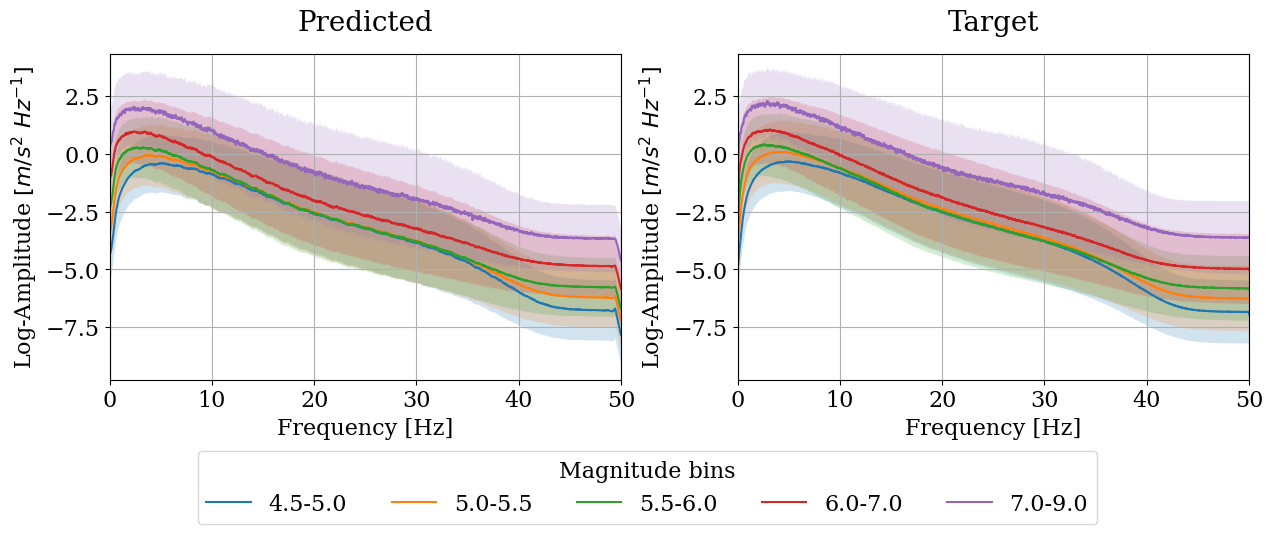

In [35]:
fig = AmplitudeSpectralDensityGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig("workdir/figures/asd_small_grid.pdf", bbox_inches="tight")

## Model ablations

In [36]:
latent_edm1d_test = h5py.File("workdir/evaluation/Latent-EDM-MovingAvg-1024x16-split_test-rank_0.h5", "r")
edm1d_test = h5py.File("workdir/evaluation/EDM-MovingAvg-split_test-rank_0.h5", "r")
latent_edm_test = h5py.File("workdir/evaluation/outputs-split_test-rank_0.h5", "r")
edm_test = h5py.File("workdir/evaluation/EDM-128x128-LogSpectrogram-split_test-rank_0.h5", "r")

In [37]:
print(latent_edm1d_test["predicted_waveform"].shape)
print(edm1d_test["predicted_waveform"].shape)
print(latent_edm_test["predicted_waveform"].shape)
print(edm_test["predicted_waveform"].shape)

(22822, 3, 4064)
(22822, 3, 4064)
(22822, 3, 4064)
(22822, 3, 4064)


In [38]:
print(f"ASD Latent EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(latent_edm_test['predicted_waveform'], latent_edm_test['target_waveform']), 2)}")
print(f"ASD Latent EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(latent_edm_test['predicted_waveform'], latent_edm_test['target_waveform']), 2)}")
print(f"ASD Latent EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(latent_edm_test['predicted_waveform'], latent_edm_test['target_waveform']), 2)}")
print()
print(f"ASD EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(edm_test['predicted_waveform'], edm_test['target_waveform']), 2)}")
print(f"ASD EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(edm_test['predicted_waveform'], edm_test['target_waveform']), 2)}")
print(f"ASD EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(edm_test['predicted_waveform'], edm_test['target_waveform']), 2)}")
print()
print(f"ASD Latent MovingAverage EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(latent_edm1d_test['predicted_waveform'], latent_edm1d_test['target_waveform']), 2)}")
print(f"ASD Latent MovingAverage EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(latent_edm1d_test['predicted_waveform'], latent_edm1d_test['target_waveform']), 2)}")
print(f"ASD Latent MovingAverage EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(latent_edm1d_test['predicted_waveform'], latent_edm1d_test['target_waveform']), 2)}")
print()
print(f"ASD MovingAverage EDM - Channel 0: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 0)(edm1d_test['predicted_waveform'], edm1d_test['target_waveform']), 2)}")
print(f"ASD MovingAverage EDM - Channel 1: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 1)(edm1d_test['predicted_waveform'], edm1d_test['target_waveform']), 2)}")
print(f"ASD MovingAverage EDM - Channel 2: Generated (Test) vs Test: {round(AmplitudeSpectralDensity(100, 2)(edm1d_test['predicted_waveform'], edm1d_test['target_waveform']), 2)}")

ASD Latent EDM - Channel 0: Generated (Test) vs Test: 24.079999923706055
ASD Latent EDM - Channel 1: Generated (Test) vs Test: 21.100000381469727
ASD Latent EDM - Channel 2: Generated (Test) vs Test: 26.450000762939453

ASD EDM - Channel 0: Generated (Test) vs Test: 907.989990234375
ASD EDM - Channel 1: Generated (Test) vs Test: 935.8699951171875
ASD EDM - Channel 2: Generated (Test) vs Test: 873.1500244140625

ASD Latent MovingAverage EDM - Channel 0: Generated (Test) vs Test: 204.25999450683594
ASD Latent MovingAverage EDM - Channel 1: Generated (Test) vs Test: 202.50999450683594
ASD Latent MovingAverage EDM - Channel 2: Generated (Test) vs Test: 207.72000122070312

ASD MovingAverage EDM - Channel 0: Generated (Test) vs Test: 2071.570068359375
ASD MovingAverage EDM - Channel 1: Generated (Test) vs Test: 2131.2900390625
ASD MovingAverage EDM - Channel 2: Generated (Test) vs Test: 2056.52001953125


In [39]:
print(f"Latent EDM - Generated (Test) classifier accuracy: {accuracy(latent_edm_test['predicted_classifier_pred'][:], get_label(latent_edm_test['magnitude'][:], latent_edm_test['hypocentral_distance'][:]))}")
print(f"EDM - Generated (Test) classifier accuracy: {accuracy(edm_test['predicted_classifier_pred'][:], get_label(edm_test['magnitude'][:], edm_test['hypocentral_distance'][:] ))}")
print(f"Latent MovingAvg EDM - Generated (Test) classifier accuracy: {accuracy(latent_edm1d_test['predicted_classifier_pred'][:], get_label(latent_edm1d_test['magnitude'][:], latent_edm1d_test['hypocentral_distance'][:] ))}")
print(f"MovingAvg EDM - Generated (Test) classifier accuracy: {accuracy(edm1d_test['predicted_classifier_pred'][:], get_label(edm1d_test['magnitude'][:], edm1d_test['hypocentral_distance'][:] ))}")

Latent EDM - Generated (Test) classifier accuracy: 67.74165279116642
EDM - Generated (Test) classifier accuracy: 62.40031548505828
Latent MovingAvg EDM - Generated (Test) classifier accuracy: 34.076768030847425
MovingAvg EDM - Generated (Test) classifier accuracy: 10.577512926123916


In [40]:
print(f"Latent EDM - Generated (Test) FD: {frechet_distance(latent_edm_test['predicted_classifier_embedding'][:], latent_edm_test['target_classifier_embedding'][:], isotropic=False)}")
print(f"EDM - Generated (Test) FD: {frechet_distance(edm_test['predicted_classifier_embedding'][:], edm_test['target_classifier_embedding'][:], isotropic=False)}")
print(f"Latent MovingAvg EDM - Generated (Test) FD: {frechet_distance(latent_edm1d_test['predicted_classifier_embedding'][:], latent_edm1d_test['target_classifier_embedding'][:], isotropic=False)}")
print(f"MovingAvg EDM - Generated (Test) FD: {frechet_distance(edm1d_test['predicted_classifier_embedding'][:], edm1d_test['target_classifier_embedding'][:], isotropic=False)}")

/tmp/ipykernel_240887/3583514326.py:16: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(cov_x @ cov_y, disp=False)


Latent EDM - Generated (Test) FD: 1.484302089587345
EDM - Generated (Test) FD: 43.2231206806664
Latent MovingAvg EDM - Generated (Test) FD: 244.03956787467087
MovingAvg EDM - Generated (Test) FD: 705.0671105812135
